## GCP Open Projcts: Predicting Hypotension from Arterial Blood Pressure (ABP) Waveforms

Jeff Mendenhall, Hannah Marshall, Ray Matsumoto, Jason Parker

### Background

- Hypotension: Low blood pressure generally defined as being below 90/60 mm Hg
- Untreated hypotension may result in irreversible organ damage and death
- Acute hypotensive episode (AHE): Any period of 30 minutes or more during which 90% of MAP is at or below 60 mmHg
- Goal is to predict hypotension from ABP waveforms in a timely manner so patients can receive appropriate care

In [1]:
from IPython.display import Image

# Image taken from https://www.cvphysiology.com/Blood%20Pressure/BP002
Image(url="https://www.cvphysiology.com/uploads/images/aortic-pulse-pressure.png", width=500, height=500)

Systolic Blood Pressure: Pressure when blood is injected into arteries

Diastolic Blood Pressure: Pressure blood exerts within arteries between heartbeats

Dicrotic Notch: Closure of aortic valve

Increase in pressure as blood enters aorta (systolic) , decrease in pressure as blood leaves aorta (diastolic)

## Data

- MIMIC II Database including both waveform and clinical data
- Training set includes 60 patients with and without AHE

## Import Packages and Copy Data over to GCP

In [2]:
from bs4 import BeautifulSoup
from get_blobs import get_blob
from google.cloud import storage
from src.utils.get_labels import get_training_labels, get_t0
from src.feature_engineering import get_sys_bp, get_dias_bp

import gcsfs  ## Google Cloud Storage file system
import os
import pandas as pd
import requests
import tarfile
import wfdb
import matplotlib.pyplot as plt
import numpy as np
import datetime

In [3]:
def fetch_settings():
    return {
        'fetch_clinical_data': False,
        'verbose': False,
        'google_cloud': {
            'project': "qwiklabs-gcp-04-133e595cc3fe"
        }
    }

fs = gcsfs.GCSFileSystem(project="qwiklabs-gcp-04-133e595cc3fe")
bucket_name = 'physionet_2009'
fs.ls(bucket_name)

['physionet_2009/mimic2cdb',
 'physionet_2009/test-set-a',
 'physionet_2009/test-set-b',
 'physionet_2009/train_wave']

In [4]:
training = get_training_labels()
record_map = pd.read_csv(
    fs.open(f'{bucket_name}/mimic2cdb/MAP', 'rb'),
    sep="\t", 
    names = ['Clinical', 'Wave', 'Sex', 'Age', 'Birthdate', 'Waveform'],
    index_col = False, 
    skiprows = [0,1])
record_map = record_map[record_map['Wave'].isin(training.keys())]

def generate_record_map():
    settings = fetch_settings()
    df = pd.read_csv(
        fs.open(f'{bucket_name}/mimic2cdb/MAP', 'rb'),
        sep="\t", 
        names = ['Clinical', 'Wave', 'Sex', 'Age', 'Birthdate', 'Waveform'],
        index_col = False, 
        skiprows = [0,1])
    df = df[df['Wave'].isin(training.keys())]
    if settings['verbose']:
        print(f"Dimensions of data set: {df.shape}")
        print(f"Data set reflects data for {len(df['Clinical'].unique().tolist())} clinical IDs")
        print(f"Data set reflects data for {len(df['Wave'].unique().tolist())} waveform IDs")
    return({'data':df, 
            'clinical_entities': df['Clinical'].unique().tolist(),
            'waveform_entities': df['Wave'].unique().tolist()
           })

def filter_data_to_entity(df, entity_colname, entity):
    return df[df[entity_colname] == entity]


def generate_waveform_dataset(e, df):
    settings = fetch_settings()
    data = filter_data_to_entity(df, 'Wave', e)
    print(data)
    data = data.squeeze().to_dict()
    result = {'raw_data': data}
    
    if settings['verbose']:
        print(data)

    print("Retrieving data from GCP")
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blobs = [i for i in bucket.list_blobs() if data['Wave'] in i.name]
    for blob in blobs:
        get_blob(bucket, blob, f"data/train_wave/{blob.name.split('/')[-1]}")
     
    print("Copy from GCP done... ")
    record = wfdb.rdrecord(f"data/train_wave/{data['Wave']}")
    return {
        'raw_data': data,
        'waveform_record': record.__dict__
    }

In [83]:
record_map = generate_record_map()

x = {e: generate_waveform_dataset(e, record_map['data']) for e in record_map['waveform_entities']}
x.keys()

   Clinical    Wave Sex Age   Birthdate    Waveform
27   s00318  a40802   M  58  11/10/1950  14/07/2009
Retrieving data from GCP
Copy from GCP done... 
   Clinical    Wave Sex Age   Birthdate    Waveform
38   s00439  a40064   F  82  22/12/1930  13/01/2013
Retrieving data from GCP


KeyboardInterrupt: 

In [6]:
def format_df(df, record, t0):
    """ Format df
    """
    df["time"] = df.index * 0.008 # from 8 ms to 1 s
    df["ts"] = df["time"].apply(lambda x: record["waveform_record"]["base_datetime"] \
                                + datetime.timedelta(seconds=x))
    
    df["age"] = record["raw_data"]["Age"]
    df["sex"] = record["raw_data"]["Sex"]
    df["clinical"] = record["raw_data"]["Clinical"]
    
    surrogate = t0[record["raw_data"]["Wave"]]
    df["before_t0"] = df["ts"].apply(lambda x: x < surrogate)
    
    #name = df["clinical"]
    #if not os.path.isdir("data/mimic2db"):
    #    os.mkdir("data/mimic2db")
    #fs.get(f'{bucket_name}/mimic2cdb/{name}/{name}.txt', f'data/mimic2db/{name}/{name}.txt')

    #clinical = parse_txt(f"data/mimic2db/{name}/{name}.txt")
    
    return df

Int64Index([10839829, 10839830, 10839831, 10839832, 10839833, 10839834,
            10839835, 10839836, 10839837, 10839838,
            ...
            10843819, 10843820, 10843821, 10843822, 10843823, 10843824,
            10843825, 10843826, 10843827, 10843828],
           dtype='int64', length=4000)
AxesSubplot(0.125,0.125;0.775x0.755)


Text(0.5, 0, 'Time (ms)')

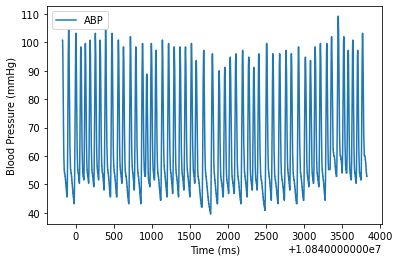

In [7]:
record = x['a40172']
t0 = get_t0()
df = pd.DataFrame(record["waveform_record"]['p_signal'], columns = record['waveform_record']['sig_name'])
df = df[~df['ABP'].isna()]
#df = format_df(df, record, t0)
window = df[['ABP']].iloc[1416000:1420000]
print(window.index)
#window = window.reset_index()

## Think we're isolating an arterial waveform show systolic and diastolic pressure
## as well as dicrotic notch
print(df[['ABP']].iloc[1416000:1420000].plot())
plt.ylabel("Blood Pressure (mmHg)")
plt.xlabel("Time (ms)")

AxesSubplot(0.125,0.125;0.775x0.755)


Text(0.5, 0, 'Time (ms)')

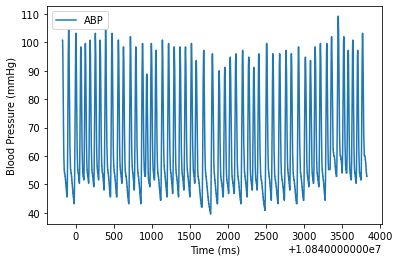

In [8]:
## Think we're isolating an arterial waveform show systolic and diastolic pressure
## as well as dicrotic notch
print(df[['ABP']].iloc[1416000:1420000].plot())
plt.ylabel("Blood Pressure (mmHg)")
plt.xlabel("Time (ms)")

failed
failed
failed
failed
failed
failed
failed
failed
failed
failed


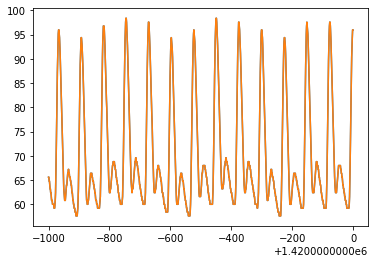

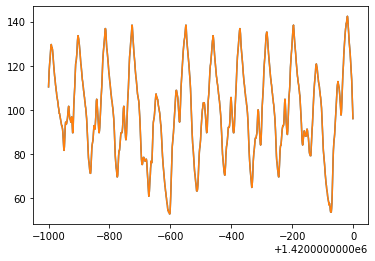

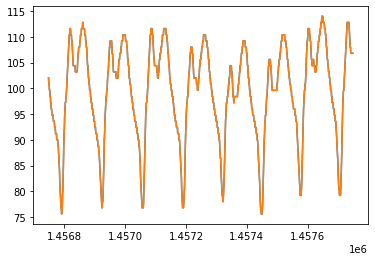

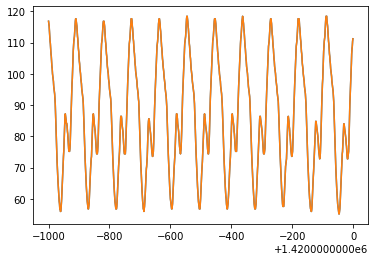

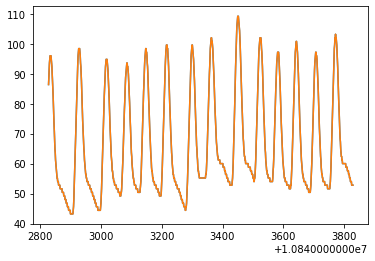

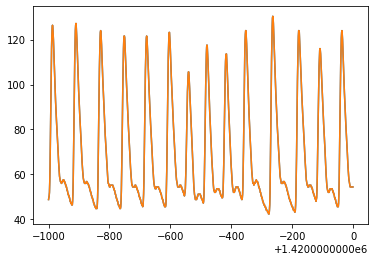

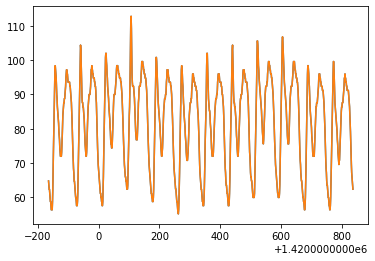

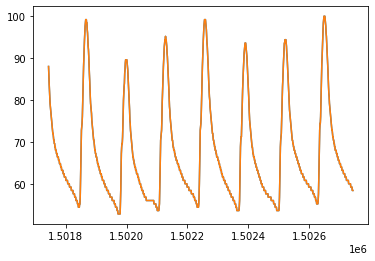

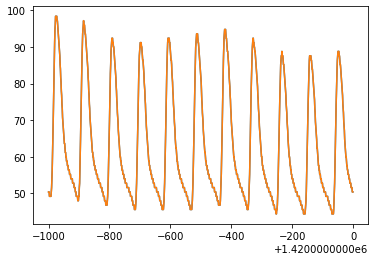

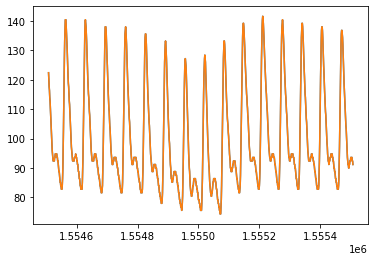

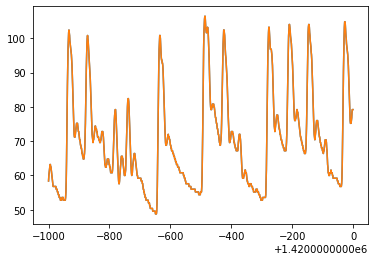

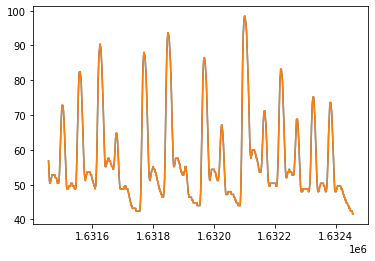

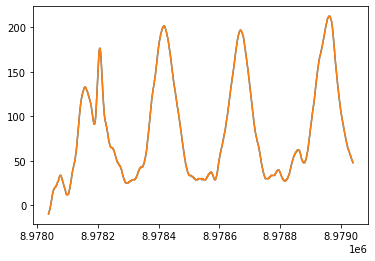

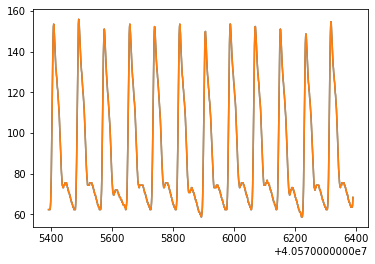

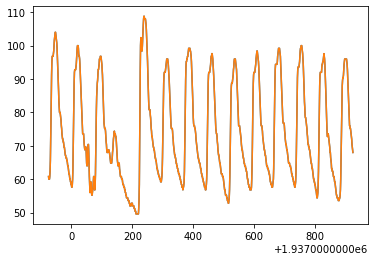

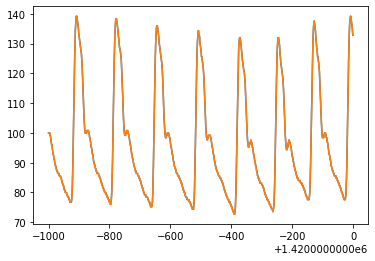

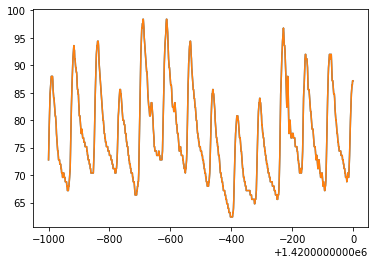

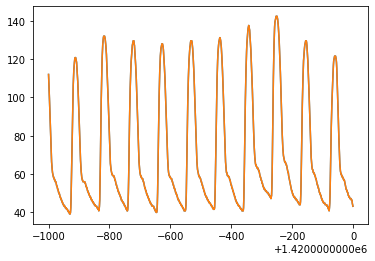

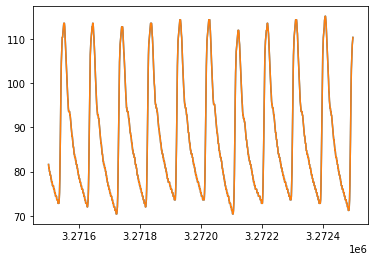

In [51]:
def do_thing(record):
    t0 = get_t0()
    df = pd.DataFrame(record["waveform_record"]['p_signal'], columns = record['waveform_record']['sig_name'])
    df = df[~df['ABP'].isna()]
    #df = format_df(df, record, t0)
    window = df[['ABP']].iloc[1416000:1420000]
    #print(window.index)
    #window = window.reset_index()

    ## Think we're isolating an arterial waveform show systolic and diastolic pressure
    ## as well as dicrotic notch
    print(df[['ABP']].iloc[1419400:1420000].plot())
    #plt.title(record)
    plt.ylabel("Blood Pressure (mmHg)")
    plt.xlabel("Time (ms)")
    
def do_thing_2(record):
    df = pd.DataFrame(record["waveform_record"]['p_signal'], columns = record['waveform_record']['sig_name'])
    df = df[~df['ABP'].isna()]
    #df = format_df(df, record, t0)
    window = df[['ABP']].iloc[1419000:1420000]
    only_sys = get_sys_bp(window)
    sys_indices = [i[0] for i in only_sys]
    sys_bp = [i[1] for i in only_sys]

    only_dias = get_dias_bp(window)
    dias_indices = [i[0] for i in only_dias]
    dias_bp = [i[1] for i in only_dias]
    fig, ax = plt.subplots()
    plt.plot(window.index, window.values)
    plt.plot(sys_indices, sys_bp, "x", color='r')
    plt.plot(dias_indices, dias_bp, "x", color='g')
    
def do_thing_3(record):
    df = pd.DataFrame(record["waveform_record"]['p_signal'], columns = record['waveform_record']['sig_name'])
    df = df[~df['ABP'].isna()]
    #df = format_df(df, record, t0)
    window = df[['ABP']].iloc[1419000:1420000]
    
    from scipy.signal import savgol_filter
    
    filtered = savgol_filter(window.values[:,0], 3, 2)
    fig, ax = plt.subplots()
    plt.plot(window.index, window.values)
    plt.plot(window.index, filtered)

for rec in list(x.values()):
    record = x[rec["waveform_record"]["record_name"]]
    try:
        do_thing_3(record)
    except:
        print("failed")
        continue

### Process Waveforms

In [10]:
from scipy.signal import find_peaks
def get_dias_bp(df):
    """ Get diastolic blood pressures for a abp waveform
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame of waveform data
    
    Returns
    -------
    only_dias : list of tuples
        Location and magnitudes of systolic blood pressures
    """
    try:
        vals = df.values[:,0]
    except:
        vals = df.values[:,1]
    peaks, _ = find_peaks(1 / vals)
    max_values = [(i, v) for i, v in zip(df.index[peaks], vals[peaks])]
    only_dias = list()
    i = 0
    while (i+1) < len(max_values):
        if max_values[i][1] < max_values[i+1][1]:
            only_dias.append(max_values[i+1])
        else:
            only_dias.append(max_values[i])
        i += 2
    print(only_dias)
        
    return only_dias

In [12]:
only_sys = get_sys_bp(window)
sys_indices = [i[0] for i in only_sys]
sys_bp = [i[1] for i in only_sys]

only_dias = get_dias_bp(window)
dias_indices = [i[0] for i in only_dias]
dias_bp = [i[1] for i in only_dias]
plt.plot(window.index, window.values)
plt.plot(sys_indices, sys_bp, "x", color='r')
plt.plot(dias_indices, dias_bp, "x", color='g')

> /home/jupyter/git_projects/waveform-fun/src/feature_engineering.py(27)get_sys_bp()
     25     #except:
     26     import pdb; pdb.set_trace()
---> 27     vals = df.values
     28     peaks, _ = find_peaks(vals, height=0)
     29     max_values = [(i, v) for i, v in zip(df.index[peaks], vals[peaks])]



ipdb>  continue


ValueError: `x` must be a 1-D array

In [ ]:
save = df[['ABP']].iloc[1419800:1420000]

save.to_csv("src/tests/files/abp.csv")

In [ ]:
from scipy.signal import butter
from scipy import signal

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide


(0.0, 200.0)

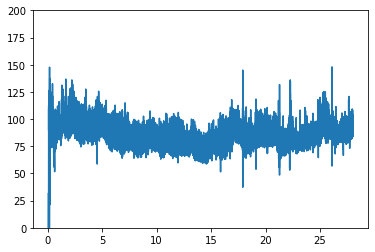

In [24]:
#df[['ABP']].plot()
record = x['a40921']
df = pd.DataFrame(record["waveform_record"]['p_signal'], columns = record['waveform_record']['sig_name'])
df = df[~df['ABP'].isna()]

only_sys = get_sys_bp(df["ABP"])
sys_indices = [i[0] for i in only_sys]
sys_bp = [i[1] for i in only_sys]

only_dias = get_dias_bp(df["ABP"])
dias_indices = [i[0] for i in only_dias]
dias_bp = [i[1] for i in only_dias]
indices, maps = calc_map(only_sys, only_dias[:96861])

plt.plot(indices*2.2222e-6, maps)
plt.ylim((0, 200))

In [44]:
def get_sys_bp(df):
    """ Get systolic blood pressures for a abp waveform
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame of waveform data
    
    Returns
    -------
    only_sys : list of tuples
        Location and magnitudes of systolic blood pressures
    """
    vals = df.values[:,0]
    peaks, _ = find_peaks(vals, height=0)
    max_values = [(i, v) for i, v in zip(df.index[peaks], vals[peaks])]
    only_sys = list()
    i = 0
    while (i+1) < len(max_values):
        if max_values[i][1] < max_values[i+1][1]:
            only_sys.append(max_values[i+1])
        else:
            only_sys.append(max_values[i])
        i += 2
        
    return only_sys

def get_dias_bp(df):
    """ Get diastolic blood pressures for a abp waveform
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame of waveform data
    
    Returns
    -------
    only_dias : list of tuples
        Location and magnitudes of systolic blood pressures
    """
    vals = df.values[:,0]
    peaks, _ = find_peaks(1 / vals)
    max_values = [(i, v) for i, v in zip(df.index[peaks], vals[peaks])]
    only_dias = list()
    i = 0
    while (i+1) < len(max_values):
        if max_values[i][1] < max_values[i+1][1]:
            only_dias.append(max_values[i])
        else:
            only_dias.append(max_values[i+1])
        i += 2
        
    return only_dias
    

def calc_map(sys, dias):
    """Calculate mean arterial blood pressure
    
    Assumes the equation: (SBPS + 2 x DBPS) / 3
    """
    sbps = np.array([i[1] for i in sys])
    dbps = np.array([i[1] for i in dias])
    
    sidx = np.array([i[0] for i in sys])
    didx = np.array([i[0] for i in dias])
    
    maps = (sbps + 2*dbps) / 3
    indices = np.mean([sidx, didx], axis=0)
    
    return indices, maps

In [ ]:
from src.feature_engineering import get_sys_bp, get_dias_bp

In [78]:
def avg_bp(x, time_chunk, time_window = 60,waveform_type = 'ABP'):
    """ Get diastolic blood pressures for a abp waveform
    
    Parameters
    ----------
    x : pd.DataFrame
        DataFrame of waveform data
        
    time_chunk: int
        number of seconds that waveform will be averaged over
        
    time_window: int
        number of seconds between each average
        
    waveform_type: str
        column of interest for waveform in primary dataframe to pull the waveform data from
    
    Returns
    -------
    new_df : pd.Dataframe
        dataframe with data about each average bp
        
        columns:
            start_window : index of start of average
            end_window : index of end of average
            avg_sys : average systolic pressure over time chunk
            avg_dias : average diastolic pressure over time chunk
            avg_map : average mean arterial pressure over time chunk
        
    """
    x = x[[waveform_type]]
    start_window = x.index[0]
    end_window = x.index[-1]
    time_window = (time_window * 1000) // 8
    time_chunk = (time_chunk * 1000) // 8
    new_df = pd.DataFrame(columns = ['start_window', 'end_window', 'avg_sys','avg_dias','avg_map', 'all_values'])
    for cur_window in range(start_window + time_chunk, end_window, time_window):

        x_sub = x.loc[cur_window-time_chunk:cur_window]
        sys_pressure = get_sys_bp(x_sub)
        dias_pressure = get_dias_bp(x_sub)
        avg_sys = np.mean([x[1] for x in sys_pressure])
        avg_dias = np.mean([x[1] for x in dias_pressure])
        avg_maps = (avg_sys + 2 * (avg_dias))/3
        try:
            #print(x_sub.tolist())
            all_values = np.array(x_sub.tolist())
        except:
            #print(x_sub.values[:,0].tolist())
            all_values = np.array(x_sub.values[:,0].tolist())
        cur_row = pd.DataFrame(data = {'start_window':[cur_window-time_chunk], 'end_window':[cur_window], 
                                       'avg_sys':[avg_sys], 'avg_dias':[avg_dias], 'avg_map':[avg_maps],'all_values':[all_values]})
        #print(cur_row)
        new_df = new_df.append(cur_row)
    new_df.sort_values('start_window')
    new_df = new_df.reset_index()
    new_df = new_df[['start_window', 'end_window', 'avg_sys', 'avg_dias','avg_map', 'all_values']]
    return new_df 

In [79]:
time_chunk = 20 * 60 # 20 minutes to seconds
bp_df = avg_bp(df, time_chunk, time_window = 60 ,waveform_type = 'ABP')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide


In [80]:
bp_df.head()

,start_window,end_window,avg_sys,avg_dias,avg_map,all_values
0,37500,187500,106.885641,62.640246,77.388711,"[-72.0, -72.0, -72.0, -72.0, -24.0, -24.0, -24..."
1,45000,195000,111.982317,67.997379,82.659025,"[100.0, 100.0, 99.2, 99.2, 98.4, 98.4, 97.6, 9..."
2,52500,202500,112.288507,67.549394,82.462432,"[122.4, 121.6, 120.0, 118.4, 117.6, 116.8, 115..."
3,60000,210000,112.250310,67.391375,82.344353,"[115.2, 112.8, 111.2, 110.4, 109.6, 109.6, 110..."
4,67500,217500,112.148378,66.937009,82.007465,"[96.8, 96.0, 94.4, 93.6, 93.6, 93.6, 93.6, 94...."


In [81]:
record_map

{'data':      Clinical    Wave Sex  Age   Birthdate    Waveform
 27     s00318  a40802   M   58  11/10/1950  14/07/2009
 38     s00439  a40064   F   82  22/12/1930  13/01/2013
 217    s02172  a40099   M   32  07/07/1982  20/10/2014
 234    s02280  a41664   M   58  04/07/1957  19/01/2016
 243    s02395  a40006   F   80  30/03/1931  02/06/2011
 258    s02561  a40225   F   81  03/09/1931  22/10/2012
 295    s03133  a41495   M   46  11/02/1969  27/06/2015
 408    s04286  a40264   M   61  04/07/1955  23/10/2016
 468    s04860  a40473   F   57  26/06/1952  25/03/2010
 482    s05126  a40384   F   69  21/06/1940  18/07/2009
 495    s05289  a40424   M   76  21/02/1934  07/12/2010
 502    s05336  a40834   M   40  17/01/1971  31/05/2011
 552    s05786  a40207   M   54  23/10/1958  27/10/2012
 585    s06180  a41385   F   45  03/07/1963  09/11/2008
 605    s06349  a40928   F   89  20/01/1921  07/07/2010
 638    s06637  a42928   M   78  28/10/1933  04/11/2011
 674    s07125  a42277   M   53  20/08/1